## WebBotShield: Network Threat Detection with ML

This project is part of the **WebBotShield** system - a Spark Structured Streaming deployment for continuous HTTP log monitoring (via Kafka/Fluentd). The system analyzes temporal patterns (burstiness), 4xx/5xx error ratios, and User-Agent diversity to distinguish human traffic from automated bot activity.

### Objective
Build a **binary classification model** to detect:
- **Normal Traffic**: Legitimate human requests
- **BotAttack**: Automated malicious traffic

### Dataset Features (Original)
| Feature | Description |
|---------|-------------|
| `Timestamp` | Request timestamp |
| `Source_IP`, `Destination_IP` | Network endpoints |
| `Port`, `Protocol` | Connection details |
| `Request_Type` | HTTP method type |
| `Payload_Size` | Request payload in bytes |
| `User_Agent` | Browser/client identifier |
| `Status` | Success/Failure |

### Engineered Features (15 total)
- **IP Aggregation** (6): request counts, unique destinations/ports, failure rates, payload stats
- **Temporal Aggregation** (2): inter-arrival time, timing consistency
- **User-Agent** (3): empty UA, tool detection, browser detection
- **Request Pattern** (2): encryption, high port detection
- **Error** (2): failure rate, protocol error rate

### Data Augmentation
Applied **SMOTE** (Synthetic Minority Over-sampling Technique) on training data to balance classes.

#### Tools

In [256]:
# !pip install shap -q

In [257]:
# Use shap 0.49.1 (0.49.0 doesn't exist; 0.50.0 requires numpy>=2)
!pip install pandas==2.3.3 numpy==1.26.4 shap==0.49.1 xgboost scikit-learn==1.7.2 matplotlib seaborn imbalanced-learn joblib==1.3.2 -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

import xgboost as xgb
import shap

## EDA

In [259]:
# Load dataset with timestamps
df = pd.read_csv("Time-Series_Network_logs.csv")
print(f"Original shape: {df.shape}")

Original shape: (8866, 11)


In [260]:
# Filter to Binary Classification: Keep only Normal and BotAttack (drop PortScan)
print("Scan_Type distribution before filtering:")
print(df['Scan_Type'].value_counts())

df = df[df['Scan_Type'].isin(['Normal', 'BotAttack'])].copy()

print(f"\nAfter filtering (Normal + BotAttack only): {df.shape}")
print(df['Scan_Type'].value_counts())
df.head()

Scan_Type distribution before filtering:
Scan_Type
Normal       8000
BotAttack     514
PortScan      352
Name: count, dtype: int64

After filtering (Normal + BotAttack only): (8514, 11)
Scan_Type
Normal       8000
BotAttack     514
Name: count, dtype: int64


,Timestamp,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,Scan_Type
0,2025-06-06 06:04:08,192.168.54.167,220.159.139.17,443,SSH,ICMP,2954,Mozilla/5.0,Success,0,Normal
1,2025-06-04 15:20:59,192.168.193.254,201.83.205.167,80,FTP,UDP,206,Wget/1.20.3,Success,0,Normal
2,2025-06-03 07:23:49,192.168.91.17,211.0.177.164,21,SSH,ICMP,977,nmap/7.80,Success,0,Normal
3,2025-06-03 11:35:42,192.168.108.75,187.49.21.67,22,HTTP,TCP,521,curl/7.68.0,Success,0,Normal
4,2025-06-05 06:09:02,192.168.245.254,189.62.16.12,53,Telnet,TCP,251,Wget/1.20.3,Success,0,Normal


## Feature Engineering

Creating **15 new features** aligned with WebBotShield's detection logic:

1. **IP Aggregation Features** (6) - Per-IP behavior statistics
2. **Temporal Aggregation Features** (2) - Time-based patterns  
3. **User-Agent Features** (3) - UA analysis for bot detection
4. **Request Pattern Features** (2) - Port analysis
5. **Error Features** (2) - Failure rate patterns

Plus keeping original: `Protocol`, `Request_Type`

In [261]:
# ============================================
# FEATURE ENGINEERING FUNCTIONS
# ============================================

def add_ip_aggregation_features(df):
    """Compute aggregated features per Source_IP"""
    df = df.sort_values('Timestamp').reset_index(drop=True)
    
    # Request count per IP
    ip_request_counts = df.groupby('Source_IP').size().reset_index(name='requests_per_ip')
    df = df.merge(ip_request_counts, on='Source_IP', how='left')
    
    # Failure rate per IP
    ip_failure = df.groupby('Source_IP').apply(
        lambda x: (x['Status'] == 'Failure').sum() / len(x)
    ).reset_index(name='failure_rate_per_ip')
    df = df.merge(ip_failure, on='Source_IP', how='left')
    
    # Payload statistics per IP
    payload_stats = df.groupby('Source_IP')['Payload_Size'].agg(['mean', 'std']).reset_index()
    payload_stats.columns = ['Source_IP', 'avg_payload_per_ip', 'payload_std_per_ip']
    payload_stats['payload_std_per_ip'] = payload_stats['payload_std_per_ip'].fillna(0)
    df = df.merge(payload_stats, on='Source_IP', how='left')
    
    return df


def add_temporal_aggregation_features(df):
    """Compute time-windowed aggregation features per IP"""
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values(['Source_IP', 'Timestamp']).reset_index(drop=True)
    
    # Inter-arrival time (seconds since last request from same IP)
    df['time_since_last_request'] = df.groupby('Source_IP')['Timestamp'].diff().dt.total_seconds().fillna(0)
    
    # Inter-arrival time std per IP (shows regularity of bot behavior)
    inter_arrival_stats = df.groupby('Source_IP')['time_since_last_request'].std().reset_index(name='inter_arrival_std')
    inter_arrival_stats['inter_arrival_std'] = inter_arrival_stats['inter_arrival_std'].fillna(0)
    df = df.merge(inter_arrival_stats, on='Source_IP', how='left')
    
    return df


def add_user_agent_features(df):
    """Extract features from User-Agent string (simplified - 3 features)"""
    # Common bot/tool user agents
    bot_keywords = ['bot', 'crawler', 'spider', 'scan', 'nmap', 'nikto', 'sqlmap', 'curl', 'wget', 'python']
    browser_keywords = ['mozilla', 'chrome', 'safari', 'firefox', 'edge', 'opera']
    
    df['ua_lower'] = df['User_Agent'].fillna('').str.lower()
    
    # Is empty user agent (suspicious)
    df['ua_is_empty'] = (df['User_Agent'].fillna('') == '').astype(int)
    
    # Contains bot/tool keywords
    df['ua_is_tool'] = df['ua_lower'].apply(lambda x: int(any(kw in x for kw in bot_keywords)))
    
    # Contains browser keywords
    df['ua_is_browser'] = df['ua_lower'].apply(lambda x: int(any(kw in x for kw in browser_keywords)))
    
    # Drop temporary column
    df.drop('ua_lower', axis=1, inplace=True)
    
    return df


def add_request_pattern_features(df):
    """Extract features from request patterns"""
    # Is encrypted connection
    df['is_encrypted'] = ((df['Port'] == 443) | (df['Request_Type'] == 'HTTPS')).astype(int)
    
    return df


def add_error_features(df):
    """Extract error-related features"""
    # Binary status
    df['is_failure'] = (df['Status'] == 'Failure').astype(int)
    
    # Error rate per protocol
    protocol_error_rate = df.groupby('Protocol')['is_failure'].mean().reset_index(name='protocol_error_rate')
    df = df.merge(protocol_error_rate, on='Protocol', how='left')
    
    return df


def engineer_all_features(df):
    """Apply all feature engineering steps"""
    print("🔧 Starting feature engineering...")
    
    print("  → Adding IP aggregation features...")
    df = add_ip_aggregation_features(df)
    
    print("  → Adding temporal aggregation features...")
    df = add_temporal_aggregation_features(df)
    
    print("  → Adding User-Agent features...")
    df = add_user_agent_features(df)
    
    print("  → Adding request pattern features...")
    df = add_request_pattern_features(df)
    
    print("  → Adding error features...")
    df = add_error_features(df)
    
    print(f"✅ Feature engineering complete! New shape: {df.shape}")
    
    return df

In [262]:
# Apply all feature engineering
df = engineer_all_features(df)
print(f"\nDataset shape after feature engineering: {df.shape}")
df.head()

🔧 Starting feature engineering...
  → Adding IP aggregation features...
  → Adding temporal aggregation features...
  → Adding User-Agent features...
  → Adding request pattern features...
  → Adding error features...
✅ Feature engineering complete! New shape: (8514, 23)

Dataset shape after feature engineering: (8514, 23)


,Timestamp,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,...,avg_payload_per_ip,payload_std_per_ip,time_since_last_request,inter_arrival_std,ua_is_empty,ua_is_tool,ua_is_browser,is_encrypted,is_failure,protocol_error_rate
0,2025-06-01 09:37:15,115.215.224.6,133.200.199.54,4444,SSH,TCP,1824,curl/7.68.0,Failure,1,...,2725.0,1173.148795,0.0,8034.791053,0,1,0,0,1,0.092725
1,2025-06-01 14:34:58,115.215.224.6,154.204.77.253,23,HTTP,TCP,3431,curl/7.68.0,Success,1,...,2725.0,1173.148795,17863.0,8034.791053,0,1,0,0,0,0.092725
2,2025-06-01 17:19:32,115.215.224.6,85.76.225.72,23,HTTP,UDP,2671,Nikto/2.1.6,Failure,1,...,2725.0,1173.148795,9874.0,8034.791053,0,1,0,0,1,0.086683
3,2025-06-01 17:47:17,115.215.224.6,137.208.231.191,135,FTP,ICMP,3322,python-requests/2.25.1,Success,1,...,2725.0,1173.148795,1665.0,8034.791053,0,1,0,0,0,0.093717
4,2025-06-01 19:00:02,115.215.224.6,148.49.188.41,8080,SSH,TCP,2392,curl/7.68.0,Success,1,...,2725.0,1173.148795,4365.0,8034.791053,0,1,0,0,0,0.092725


In [263]:
# List all engineered features
new_features = [
    # IP Aggregation (4) - removed unique_destinations_per_ip, unique_ports_per_ip
    'requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip',
    # Temporal Aggregation (2)
    'time_since_last_request', 'inter_arrival_std',
    # User-Agent (3)
    'ua_is_empty', 'ua_is_tool', 'ua_is_browser',
    # Request Pattern (1) - removed is_high_port
    'is_encrypted',
    # Error (2)
    'is_failure', 'protocol_error_rate'
]

print(f"📊 Engineered features: {len(new_features)}")
print("\nBy category:")
print("  → IP Aggregation: 4 features")
print("  → Temporal Aggregation: 2 features")
print("  → User-Agent: 3 features")
print("  → Request Pattern: 1 feature")
print("  → Error: 2 features")
print("\n✅ Also keeping: Protocol, Request_Type (original categorical features)")

print(f"\nFeature summary:")
df[new_features].describe()

📊 Engineered features: 12

By category:
  → IP Aggregation: 4 features
  → Temporal Aggregation: 2 features
  → User-Agent: 3 features
  → Request Pattern: 1 feature
  → Error: 2 features

✅ Also keeping: Protocol, Request_Type (original categorical features)

Feature summary:


,requests_per_ip,failure_rate_per_ip,avg_payload_per_ip,payload_std_per_ip,time_since_last_request,inter_arrival_std,ua_is_empty,ua_is_tool,ua_is_browser,is_encrypted,is_failure,protocol_error_rate
count,8514.000000,8514.000000,8514.000000,8514.000000,8514.000000,8514.000000,8514.0,8514.000000,8514.000000,8514.000000,8514.000000,8514.000000
mean,4.355180,0.091027,1666.584919,149.168129,10876.620860,15075.130887,0.0,0.831454,0.168546,0.264271,0.091027,0.091027
std,13.098359,0.261384,801.851037,386.954015,51517.698207,50252.338212,0.0,0.374372,0.374372,0.440970,0.287664,0.003117
min,1.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.086683
25%,1.000000,0.000000,992.250000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.086683
50%,1.000000,0.000000,1685.500000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.092725
75%,1.000000,0.000000,2408.750000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.093717
max,70.000000,1.000000,2999.000000,1891.510640,494928.000000,349966.944999,0.0,1.000000,1.000000,1.000000,1.000000,0.093717


## Feature Correlation with Target

Analyze which features have the strongest correlation with BotAttack detection.

In [264]:
# Create binary target variable
df['target'] = (df['Scan_Type'] == 'BotAttack').astype(int)
print(f"Target distribution:\n{df['target'].value_counts()}")
print(f"\nTarget balance: {df['target'].mean():.2%} BotAttack")

Target distribution:
target
0    8000
1     514
Name: count, dtype: int64

Target balance: 6.04% BotAttack


In [265]:
# SMOTE will be applied after train/test split to avoid data leakage
# We'll apply SMOTE only on training data
print("📈 SMOTE augmentation will be applied after train/test split")
print(f"   Current class distribution: {df['target'].value_counts().to_dict()}")

📈 SMOTE augmentation will be applied after train/test split
   Current class distribution: {0: 8000, 1: 514}


In [266]:
# Calculate correlation of all numeric features with target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['target', 'Intrusion']]

correlations = df[numeric_cols + ['target']].corr()['target'].drop('target').sort_values(key=abs, ascending=False)

# Display top correlations
print("📈 Top 15 Features Correlated with BotAttack (by absolute value):\n")
for feat, corr in correlations.head(15).items():
    direction = "↑" if corr > 0 else "↓"
    print(f"  {direction} {feat:30s}: {corr:+.4f}")

📈 Top 15 Features Correlated with BotAttack (by absolute value):

  ↑ requests_per_ip               : +0.9739
  ↑ payload_std_per_ip            : +0.7513
  ↑ failure_rate_per_ip           : +0.6306
  ↑ Port                          : +0.6020
  ↑ is_failure                    : +0.5730
  ↑ avg_payload_per_ip            : +0.3213
  ↑ Payload_Size                  : +0.2920
  ↓ is_encrypted                  : -0.0781
  ↓ inter_arrival_std             : -0.0281
  ↓ ua_is_browser                 : -0.0180
  ↑ ua_is_tool                    : +0.0180
  ↓ protocol_error_rate           : -0.0066
  ↓ time_since_last_request       : -0.0064
  ↓ ua_is_empty                   : +nan


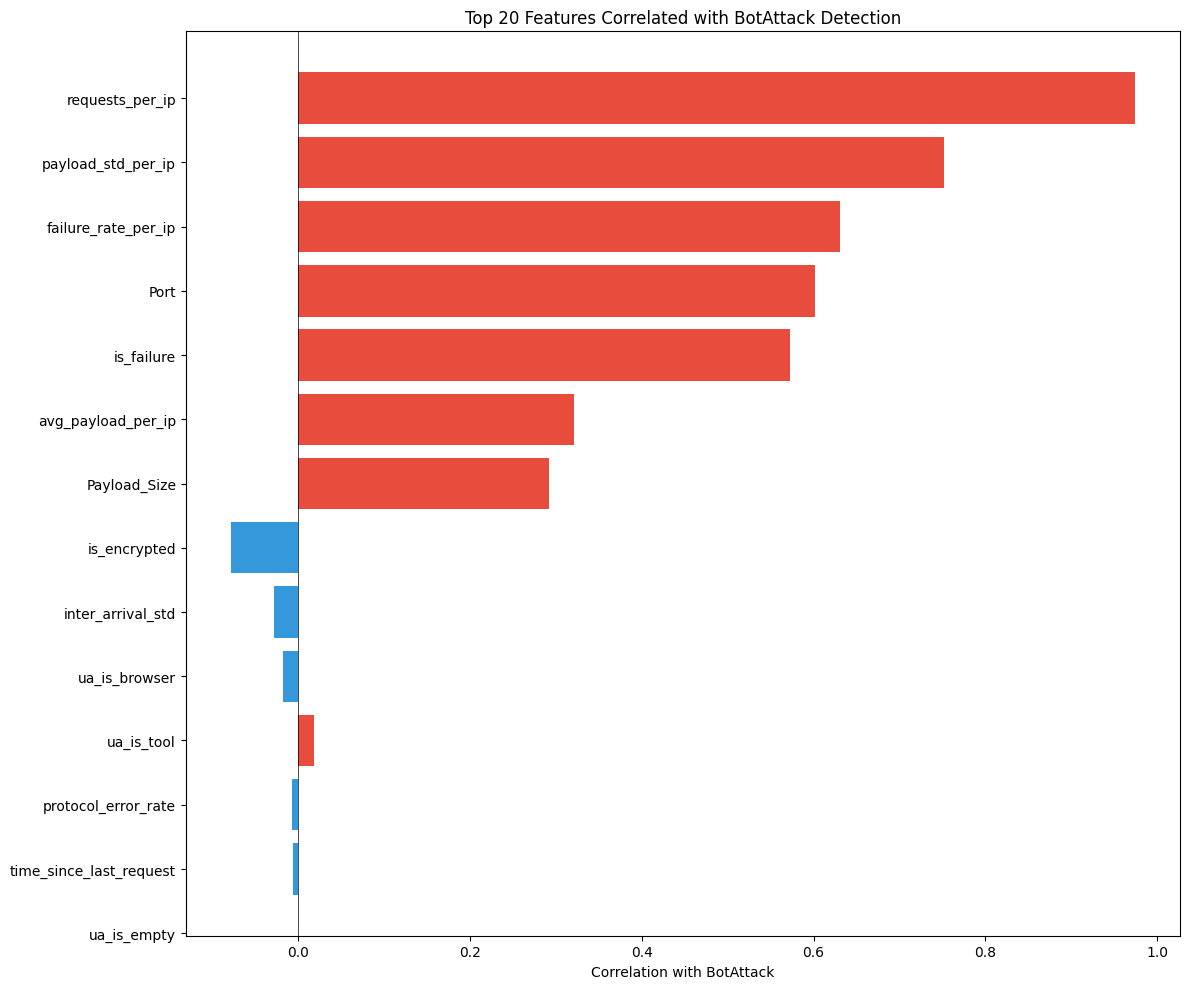


🔴 Red = Positive correlation (higher value → more likely BotAttack)
🔵 Blue = Negative correlation (higher value → more likely Normal)


In [267]:
# Visualize feature correlations with target
plt.figure(figsize=(12, 10))
top_features = correlations.head(20)
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_features.values]
plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with BotAttack')
plt.title('Top 20 Features Correlated with BotAttack Detection')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🔴 Red = Positive correlation (higher value → more likely BotAttack)")
print("🔵 Blue = Negative correlation (higher value → more likely Normal)")

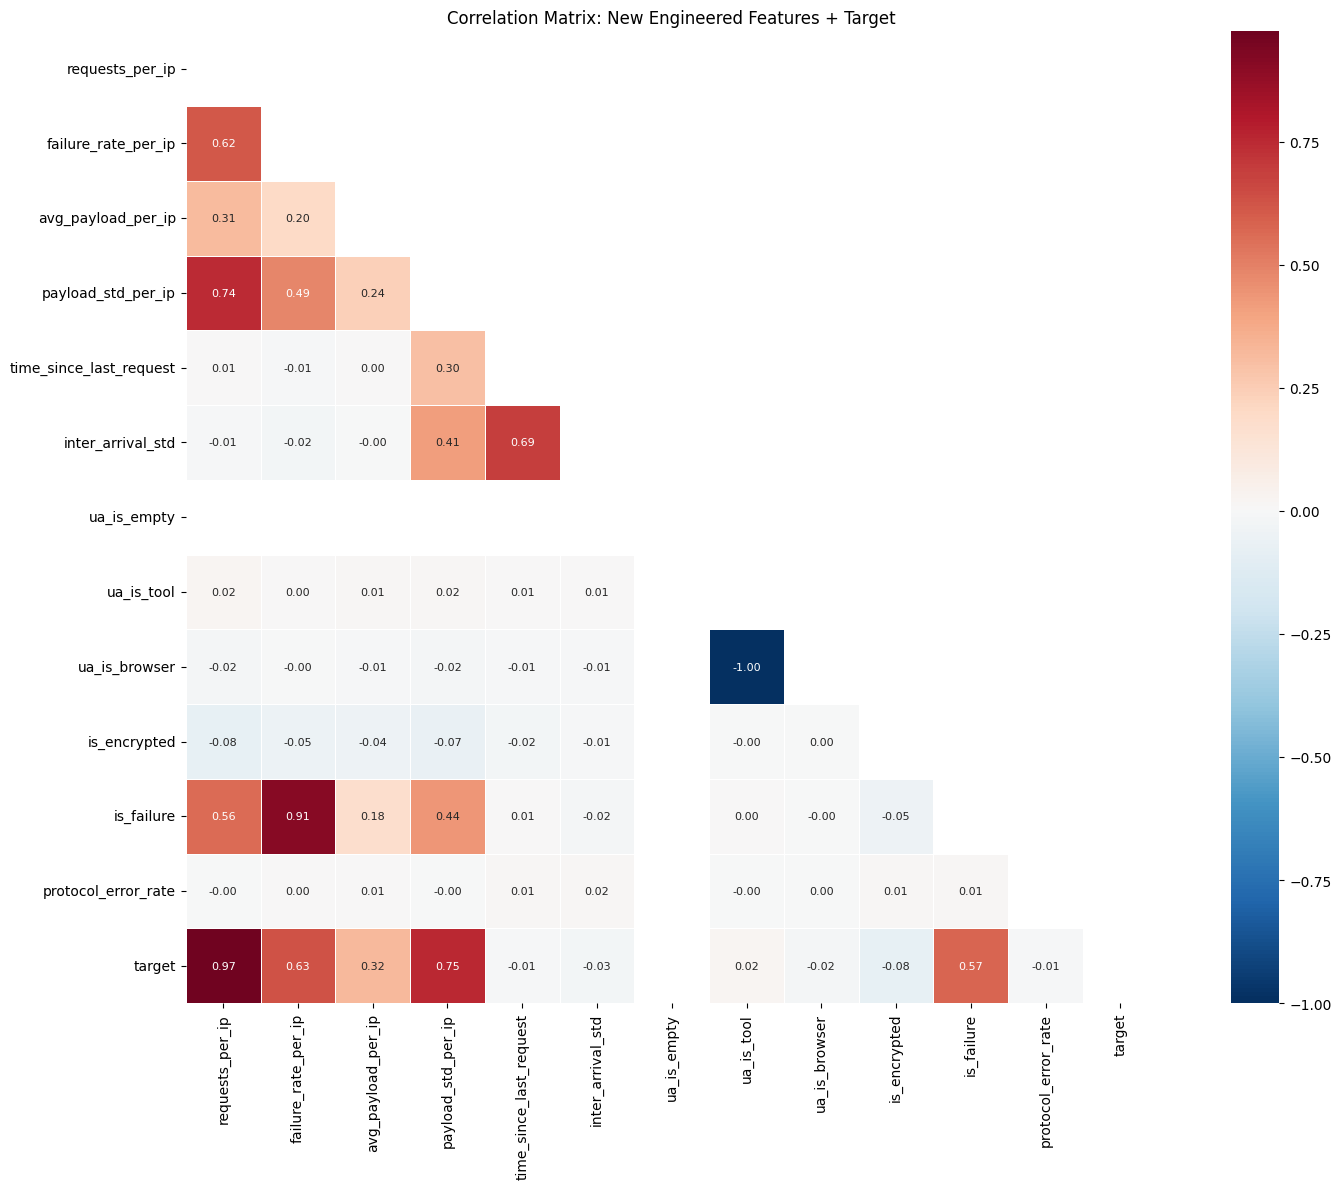

In [268]:
# Correlation heatmap for new engineered features
plt.figure(figsize=(16, 12))
# Select only numeric new features that exist in the dataframe
available_new_features = [f for f in new_features if f in df.columns]
corr_matrix = df[available_new_features + ['target']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5, annot_kws={'size': 8})
plt.title('Correlation Matrix: New Engineered Features + Target')
plt.tight_layout()
plt.show()

## Feature Importance Analysis (Pre-Model)

Use a quick Random Forest to identify feature importance before full model training.

In [269]:
# Prepare features for quick importance analysis
# Drop only non-numeric and identifier columns
drop_cols = ['Timestamp', 'Source_IP', 'Destination_IP', 'User_Agent', 'Status', 
             'Scan_Type', 'target', 'Intrusion'  # Intrusion = same as target (leaky)
            ]
feature_cols = [col for col in df.columns if col not in drop_cols]

# Encode any remaining categorical columns
df_encoded = df.copy()
for col in ['Request_Type', 'Protocol']:
    if col in df_encoded.columns and df_encoded[col].dtype == 'object':
        df_encoded[col] = df_encoded[col].astype('category').cat.codes

X_importance = df_encoded[feature_cols].copy()
# Handle any remaining non-numeric
for col in X_importance.columns:
    if X_importance[col].dtype == 'object':
        X_importance[col] = X_importance[col].astype('category').cat.codes

y_importance = df['target']

print(f"Features for importance analysis: {X_importance.shape[1]}")
print(f"Sample size: {len(y_importance)}")
print(f"\nFeature list:")
print(X_importance.columns.tolist())

Features for importance analysis: 16
Sample size: 8514

Feature list:
['Port', 'Request_Type', 'Protocol', 'Payload_Size', 'requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip', 'time_since_last_request', 'inter_arrival_std', 'ua_is_empty', 'ua_is_tool', 'ua_is_browser', 'is_encrypted', 'is_failure', 'protocol_error_rate']


In [270]:
# Train a quick Random Forest for feature importance
from sklearn.ensemble import RandomForestClassifier

rf_quick = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_quick.fit(X_importance, y_importance)

# Get feature importances
importances = pd.DataFrame({
    'feature': X_importance.columns,
    'importance': rf_quick.feature_importances_
}).sort_values('importance', ascending=False)

print("🌲 Random Forest Feature Importance (Top 20):\n")
for i, row in importances.head(20).iterrows():
    bar = "█" * int(row['importance'] * 100)
    print(f"  {row['feature']:30s}: {row['importance']:.4f} {bar}")

🌲 Random Forest Feature Importance (Top 20):

  requests_per_ip               : 0.3465 ██████████████████████████████████
  payload_std_per_ip            : 0.1850 ██████████████████
  failure_rate_per_ip           : 0.1442 ██████████████
  Port                          : 0.1021 ██████████
  time_since_last_request       : 0.0752 ███████
  inter_arrival_std             : 0.0475 ████
  avg_payload_per_ip            : 0.0374 ███
  Payload_Size                  : 0.0368 ███
  is_failure                    : 0.0250 ██
  is_encrypted                  : 0.0003 
  Protocol                      : 0.0000 
  ua_is_browser                 : 0.0000 
  Request_Type                  : 0.0000 
  protocol_error_rate           : 0.0000 
  ua_is_tool                    : 0.0000 
  ua_is_empty                   : 0.0000 


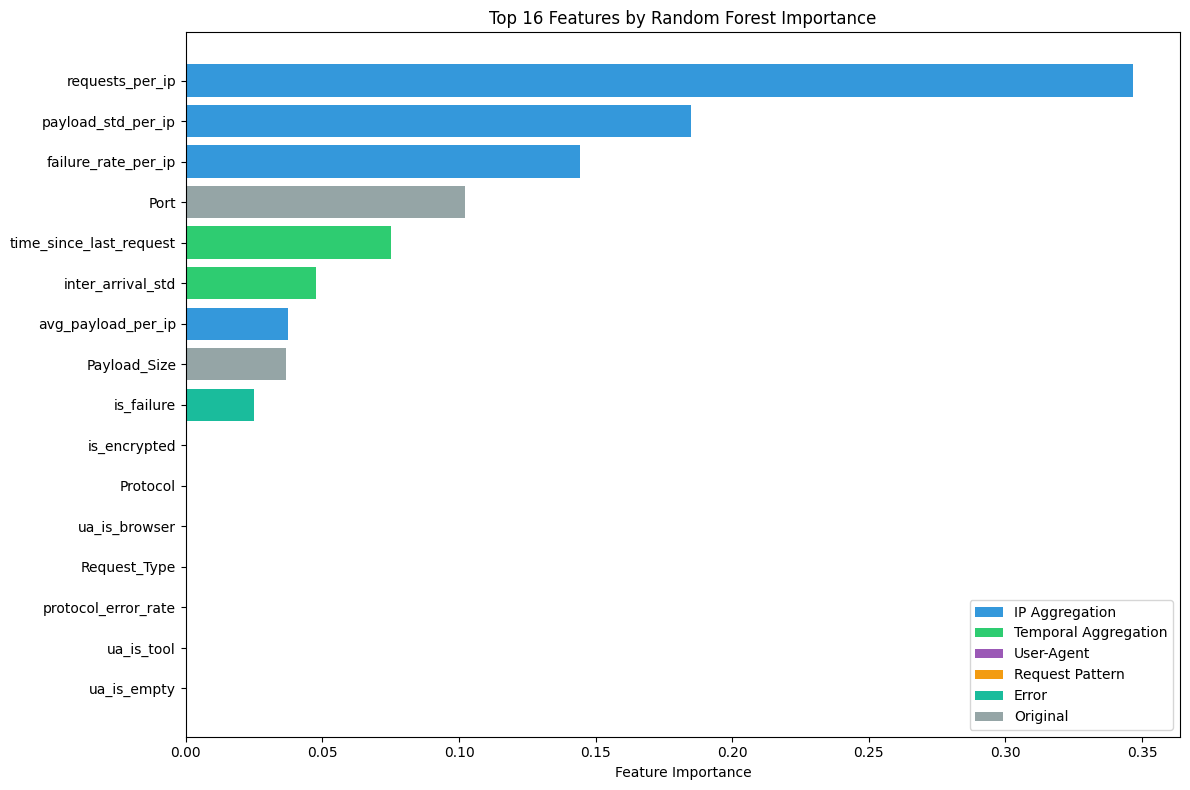

In [271]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_n = min(20, len(importances))
top_importances = importances.head(top_n)

# Color by feature category
def get_feature_category(feat):
    ip_agg = ['requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip']
    temporal_agg = ['time_since_last_request', 'inter_arrival_std']
    user_agent = ['ua_is_empty', 'ua_is_tool', 'ua_is_browser']
    request = ['is_encrypted']
    error = ['is_failure', 'protocol_error_rate']
    
    if feat in ip_agg: return '#3498db'       # Blue
    if feat in temporal_agg: return '#2ecc71' # Green
    if feat in user_agent: return '#9b59b6'   # Purple
    if feat in request: return '#f39c12'      # Orange
    if feat in error: return '#1abc9c'        # Teal
    return '#95a5a6'  # Gray (original features)

colors = [get_feature_category(f) for f in top_importances['feature']]

plt.barh(range(len(top_importances)), top_importances['importance'], color=colors)
plt.yticks(range(len(top_importances)), top_importances['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Features by Random Forest Importance')
plt.gca().invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', label='IP Aggregation'),
    Patch(facecolor='#2ecc71', label='Temporal Aggregation'),
    Patch(facecolor='#9b59b6', label='User-Agent'),
    Patch(facecolor='#f39c12', label='Request Pattern'),
    Patch(facecolor='#1abc9c', label='Error'),
    Patch(facecolor='#95a5a6', label='Original')
]
plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

📊 Feature Importance by Category:

  IP Aggregation      : 0.7130
  Temporal Aggregation: 0.1227
  User-Agent          : 0.0000
  Request Pattern     : 0.0003
  Error               : 0.0250


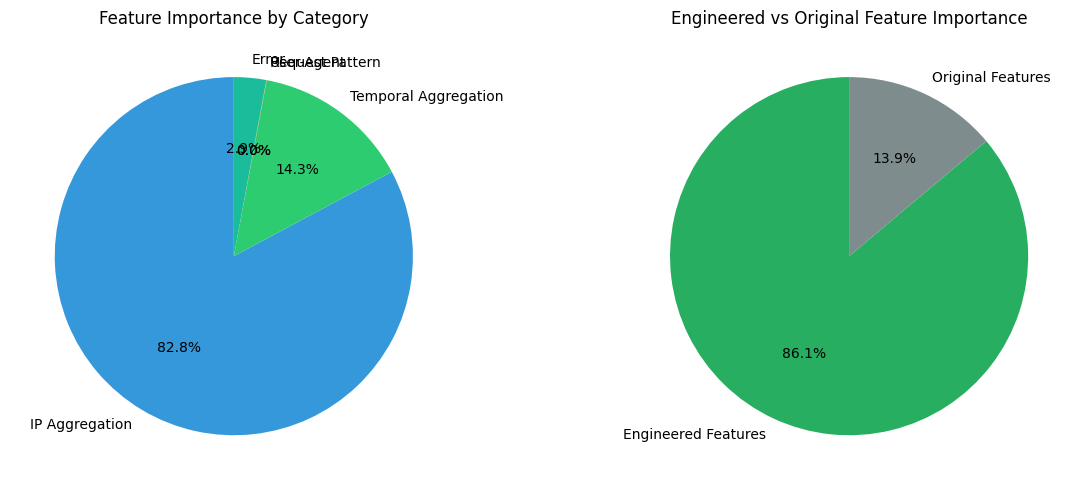

In [272]:
# Feature importance by category
category_importance = {
    'IP Aggregation': ['requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip'],
    'Temporal Aggregation': ['time_since_last_request', 'inter_arrival_std'],
    'User-Agent': ['ua_is_empty', 'ua_is_tool', 'ua_is_browser'],
    'Request Pattern': ['is_encrypted'],
    'Error': ['is_failure', 'protocol_error_rate']
}

print("📊 Feature Importance by Category:\n")
category_scores = {}
for cat, features in category_importance.items():
    available_feats = [f for f in features if f in importances['feature'].values]
    if available_feats:
        cat_importance = importances[importances['feature'].isin(available_feats)]['importance'].sum()
        category_scores[cat] = cat_importance
        print(f"  {cat:20s}: {cat_importance:.4f}")

# Pie chart for category importance
if category_scores:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    colors_pie = ['#3498db', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']
    non_zero_scores = {k: v for k, v in category_scores.items() if v > 0}
    if non_zero_scores:
        plt.pie(non_zero_scores.values(), labels=non_zero_scores.keys(), autopct='%1.1f%%', 
                colors=colors_pie[:len(non_zero_scores)], startangle=90)
        plt.title('Feature Importance by Category')

    # Original vs New features
    plt.subplot(1, 2, 2)
    all_new_features = [f for cat_feats in category_importance.values() for f in cat_feats]
    new_importance = importances[importances['feature'].isin(all_new_features)]['importance'].sum()
    original_importance = importances[~importances['feature'].isin(all_new_features)]['importance'].sum()

    plt.pie([new_importance, original_importance], labels=['Engineered Features', 'Original Features'], 
            autopct='%1.1f%%', colors=['#27ae60', '#7f8c8d'], startangle=90)
    plt.title('Engineered vs Original Feature Importance')
    plt.tight_layout()
    plt.show()

## Feature Distribution by Target Class

Visualize how key features differ between Normal and BotAttack traffic.

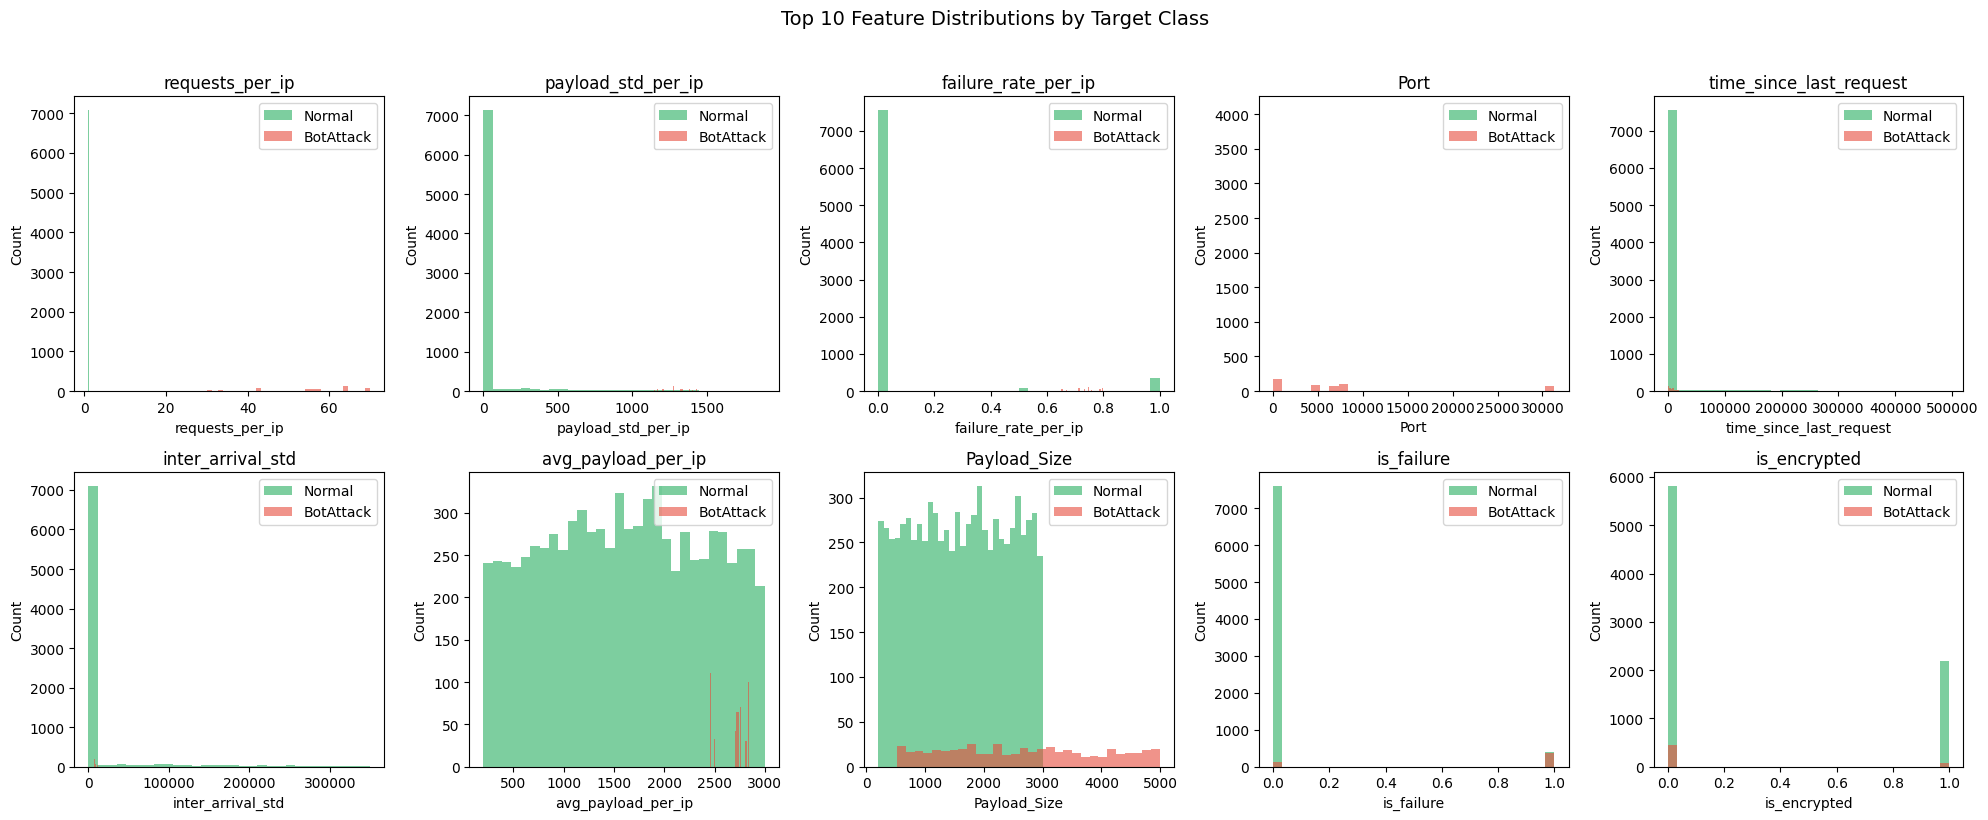

In [273]:
# Distribution of top features by target class
top_10_features = importances.head(10)['feature'].tolist()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, feat in enumerate(top_10_features):
    if feat in df.columns:
        ax = axes[i]
        for label, color in [(0, '#27ae60'), (1, '#e74c3c')]:
            subset = df[df['target'] == label][feat]
            ax.hist(subset, bins=30, alpha=0.6, label=f"{'Normal' if label == 0 else 'BotAttack'}", color=color)
        ax.set_title(f'{feat}')
        ax.legend()
        ax.set_xlabel(feat)
        ax.set_ylabel('Count')

plt.suptitle('Top 10 Feature Distributions by Target Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [274]:
# Statistical comparison of features between Normal and BotAttack
print("📊 Feature Statistics by Target Class:\n")
print(f"{'Feature':<30} {'Normal Mean':>12} {'BotAttack Mean':>14} {'Diff':>10}")
print("-" * 70)

for feat in importances.head(15)['feature'].tolist():
    if feat in df.columns and df[feat].dtype in ['int64', 'float64']:
        normal_mean = df[df['target'] == 0][feat].mean()
        bot_mean = df[df['target'] == 1][feat].mean()
        diff = bot_mean - normal_mean
        indicator = "↑" if diff > 0 else "↓"
        print(f"{feat:<30} {normal_mean:>12.4f} {bot_mean:>14.4f} {indicator}{abs(diff):>9.4f}")

📊 Feature Statistics by Target Class:

Feature                         Normal Mean BotAttack Mean       Diff
----------------------------------------------------------------------
requests_per_ip                      1.1220        54.6770 ↑  53.5550
payload_std_per_ip                  75.4854      1295.9806 ↑1220.4952
failure_rate_per_ip                  0.0493         0.7412 ↑   0.6920
Port                               103.0741      8200.9669 ↑8097.8928
time_since_last_request          10960.5565      9570.2296 ↓1390.3269
inter_arrival_std                15432.9157      9506.4959 ↓5926.4197
avg_payload_per_ip                1601.2877      2682.8833 ↑1081.5955
Payload_Size                      1601.2877      2682.8833 ↑1081.5955
is_failure                           0.0493         0.7412 ↑   0.6920
is_encrypted                         0.2730         0.1284 ↓   0.1446
ua_is_browser                        0.1703         0.1420 ↓   0.0282
protocol_error_rate                  0.0910       

In [275]:
# Dataset info
print("Dataset columns:")
print(df.columns.tolist())
print(f"\nDataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")

Dataset columns:
['Timestamp', 'Source_IP', 'Destination_IP', 'Port', 'Request_Type', 'Protocol', 'Payload_Size', 'User_Agent', 'Status', 'Intrusion', 'Scan_Type', 'requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip', 'time_since_last_request', 'inter_arrival_std', 'ua_is_empty', 'ua_is_tool', 'ua_is_browser', 'is_encrypted', 'is_failure', 'protocol_error_rate', 'target']

Dataset shape: (8514, 24)

Data types:
Timestamp                  datetime64[ns]
Source_IP                          object
Destination_IP                     object
Port                                int64
Request_Type                       object
Protocol                           object
Payload_Size                        int64
User_Agent                         object
Status                             object
Intrusion                           int64
Scan_Type                          object
requests_per_ip                     int64
failure_rate_per_ip               float64
avg_pay

In [276]:
df.isnull().sum()


Timestamp                  0
Source_IP                  0
Destination_IP             0
Port                       0
Request_Type               0
Protocol                   0
Payload_Size               0
User_Agent                 0
Status                     0
Intrusion                  0
Scan_Type                  0
requests_per_ip            0
failure_rate_per_ip        0
avg_payload_per_ip         0
payload_std_per_ip         0
time_since_last_request    0
inter_arrival_std          0
ua_is_empty                0
ua_is_tool                 0
ua_is_browser              0
is_encrypted               0
is_failure                 0
protocol_error_rate        0
target                     0
dtype: int64

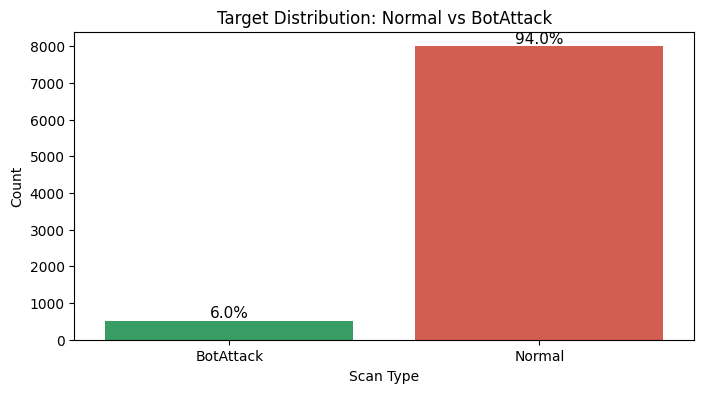

Scan_Type
Normal       0.94
BotAttack    0.06
Name: proportion, dtype: float64


In [277]:
# Target distribution (Binary: Normal vs BotAttack)
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Scan_Type', data=df, palette=['#27ae60', '#e74c3c'])
plt.title('Target Distribution: Normal vs BotAttack')
plt.xlabel('Scan Type')
plt.ylabel('Count')

# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.show()

print(df['Scan_Type'].value_counts(normalize=True).round(3))

### Observations:
- **Binary Classification**: Normal traffic vs BotAttack detection
- **Class Imbalance**: We may need to apply SMOTE or class weights during model training

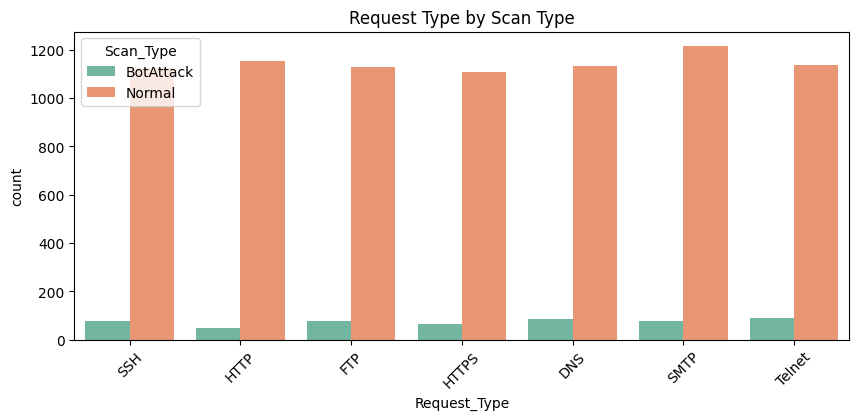

In [278]:
plt.figure(figsize=(10, 4))
sns.countplot(x='Request_Type', hue='Scan_Type', data=df, palette='Set2')
plt.title('Request Type by Scan Type')
plt.xticks(rotation=45)
plt.show()


The scan_type distribution aginst request_type is semi-balanced, there is no certain request type that guarntee a bot attack.

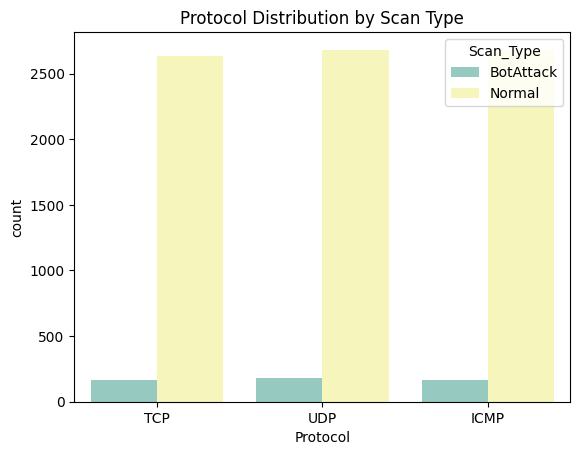

In [279]:
sns.countplot(x='Protocol', hue='Scan_Type', data=df, palette='Set3')
plt.title('Protocol Distribution by Scan Type')
plt.show()


Same Conclusion As Above.

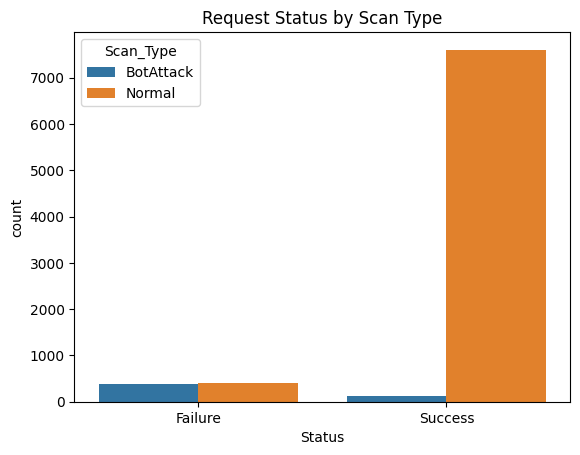

In [280]:
sns.countplot(x='Status', hue='Scan_Type', data=df)
plt.title('Request Status by Scan Type')
plt.show()


Most Normal requests are successful, while BotAttack and PortScan requests often fail. This suggests that the Status feature can help distinguish between normal and malicious traffic.

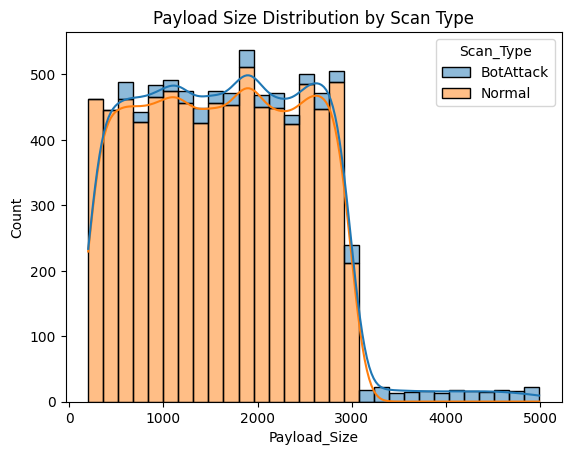

In [281]:
sns.histplot(data=df, x='Payload_Size', hue='Scan_Type', bins=30, kde=True, multiple='stack')
plt.title('Payload Size Distribution by Scan Type')
plt.show()


Normal traffic has a wide range of payload sizes, while BotAttack are mostly  big payloads. and PortScan payloads are limited to samll sizes, This suggests that payload size is a strong feature for distinguishing malicious activity.

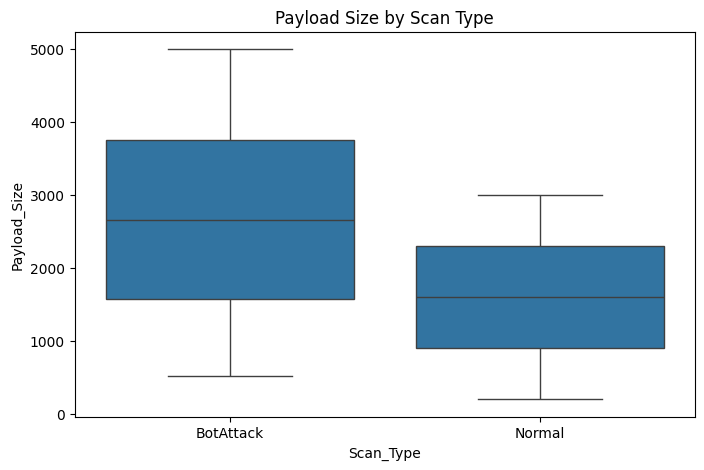

In [282]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Scan_Type', y='Payload_Size', data=df)
plt.title('Payload Size by Scan Type')
plt.show()


Same conclusions as before.

In [283]:
top_sources = df['Source_IP'].value_counts().head(10)
top_dest = df['Destination_IP'].value_counts().head(10)

print("Top 10 Source IPs:")
print(top_sources)

print("\nTop 10 Destination IPs:")
print(top_dest)


Top 10 Source IPs:
Source_IP
200.87.146.138    70
3.222.94.132      64
115.215.224.6     64
183.212.254.5     57
38.233.224.217    56
195.86.201.230    55
214.149.139.61    43
166.225.57.211    42
130.101.244.72    33
136.175.68.68     30
Name: count, dtype: int64

Top 10 Destination IPs:
Destination_IP
133.200.199.54     1
154.204.77.253     1
85.76.225.72       1
137.208.231.191    1
148.49.188.41      1
222.245.84.69      1
31.188.185.226     1
131.26.200.62      1
9.214.66.96        1
211.16.196.136     1
Name: count, dtype: int64


We won't take into account the ip sources, since it is not a very refelctive and can not be generalized.

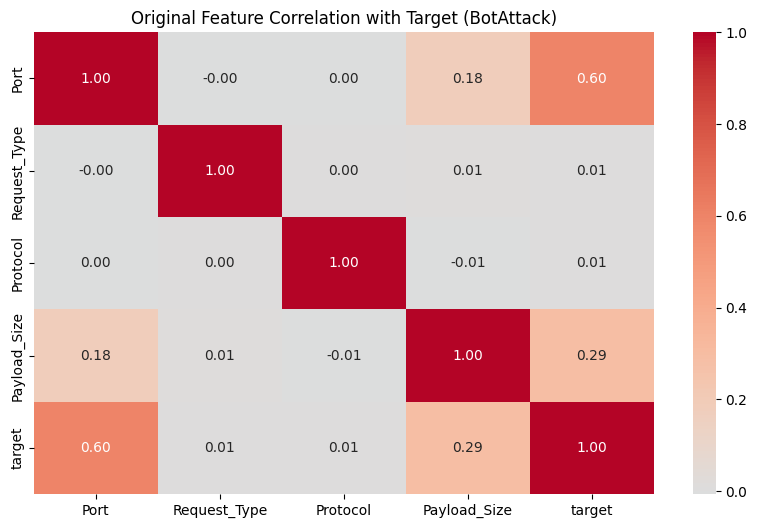


⚠️ Note: 'Intrusion' column removed - it's identical to target (data leakage)


In [284]:
# Correlation heatmap of original features (excluding Intrusion - same as target)
df_original = df[['Port', 'Request_Type', 'Protocol', 'Payload_Size']].copy()

# Encode categoricals for correlation
for col in ['Request_Type', 'Protocol']:
    if col in df_original.columns and df_original[col].dtype == 'object':
        df_original[col] = df_original[col].astype('category').cat.codes

# Add target
df_original['target'] = df['target']

plt.figure(figsize=(10, 6))
sns.heatmap(df_original.corr(), annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Original Feature Correlation with Target (BotAttack)')
plt.show()

print("\n⚠️ Note: 'Intrusion' column removed - it's identical to target (data leakage)")

There is no any strong colinearity between any two features, so we can proceed to the next step without droping any features.

## Data preparation

In [285]:
df

,Timestamp,Source_IP,Destination_IP,Port,Request_Type,Protocol,Payload_Size,User_Agent,Status,Intrusion,...,payload_std_per_ip,time_since_last_request,inter_arrival_std,ua_is_empty,ua_is_tool,ua_is_browser,is_encrypted,is_failure,protocol_error_rate,target
0,2025-06-01 09:37:15,115.215.224.6,133.200.199.54,4444,SSH,TCP,1824,curl/7.68.0,Failure,1,...,1173.148795,0.0,8034.791053,0,1,0,0,1,0.092725,1
1,2025-06-01 14:34:58,115.215.224.6,154.204.77.253,23,HTTP,TCP,3431,curl/7.68.0,Success,1,...,1173.148795,17863.0,8034.791053,0,1,0,0,0,0.092725,1
2,2025-06-01 17:19:32,115.215.224.6,85.76.225.72,23,HTTP,UDP,2671,Nikto/2.1.6,Failure,1,...,1173.148795,9874.0,8034.791053,0,1,0,0,1,0.086683,1
3,2025-06-01 17:47:17,115.215.224.6,137.208.231.191,135,FTP,ICMP,3322,python-requests/2.25.1,Success,1,...,1173.148795,1665.0,8034.791053,0,1,0,0,0,0.093717,1
4,2025-06-01 19:00:02,115.215.224.6,148.49.188.41,8080,SSH,TCP,2392,curl/7.68.0,Success,1,...,1173.148795,4365.0,8034.791053,0,1,0,0,0,0.092725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,2025-06-06 11:52:50,38.233.224.217,67.83.57.236,4444,HTTP,UDP,4546,Wget/1.20.3,Failure,1,...,1280.298797,930.0,8156.990541,0,1,0,0,1,0.086683,1
8510,2025-06-06 12:09:09,38.233.224.217,118.182.114.232,4444,FTP,ICMP,3361,Wget/1.20.3,Success,1,...,1280.298797,979.0,8156.990541,0,1,0,0,0,0.093717,1
8511,2025-06-06 13:21:37,38.233.224.217,17.73.20.186,23,SSH,UDP,2224,python-requests/2.25.1,Failure,1,...,1280.298797,4348.0,8156.990541,0,1,0,0,1,0.086683,1
8512,2025-06-06 19:05:22,38.233.224.217,56.158.38.68,23,Telnet,UDP,3072,curl/7.68.0,Failure,1,...,1280.298797,20625.0,8156.990541,0,1,0,0,1,0.086683,1


Drop irrelevant or high-cardinality features

In [286]:
# Drop only identifier columns and Intrusion (same as target = data leakage)
drop_columns = ['Source_IP', 'Destination_IP', 'Timestamp', 'User_Agent', 'Status', 'Scan_Type', 
                'Intrusion'  # Same as target - data leakage!
               ]
df.drop(drop_columns, axis=1, inplace=True, errors='ignore')
print(f"Dropped columns: {drop_columns}")
print(f"\n✅ Keeping: Protocol, Request_Type, protocol_error_rate (for model generalization)")

Dropped columns: ['Source_IP', 'Destination_IP', 'Timestamp', 'User_Agent', 'Status', 'Scan_Type', 'Intrusion']

✅ Keeping: Protocol, Request_Type, protocol_error_rate (for model generalization)


Convert categorical_cols into int columns using LabelEncoder

In [287]:
# Encode categorical columns
categorical_cols = ['Request_Type', 'Protocol']
for col in categorical_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
        print(f"Encoded {col}: {df[col].nunique()} unique values")

Encoded Request_Type: 7 unique values
Encoded Protocol: 3 unique values


Show encoded category values

In [288]:
# Show remaining columns
print("Columns after preprocessing:")
print(df.columns.tolist())
print(f"\nShape: {df.shape}")

Columns after preprocessing:
['Port', 'Request_Type', 'Protocol', 'Payload_Size', 'requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip', 'time_since_last_request', 'inter_arrival_std', 'ua_is_empty', 'ua_is_tool', 'ua_is_browser', 'is_encrypted', 'is_failure', 'protocol_error_rate', 'target']

Shape: (8514, 17)


Encode target label

In [289]:
# Target is already created as 'target' column (binary: 0=Normal, 1=BotAttack)
print("Target distribution:")
print(df['target'].value_counts())
print(f"\nTarget mapping: 0 = Normal, 1 = BotAttack")

Target distribution:
target
0    8000
1     514
Name: count, dtype: int64

Target mapping: 0 = Normal, 1 = BotAttack


In [290]:
df

,Port,Request_Type,Protocol,Payload_Size,requests_per_ip,failure_rate_per_ip,avg_payload_per_ip,payload_std_per_ip,time_since_last_request,inter_arrival_std,ua_is_empty,ua_is_tool,ua_is_browser,is_encrypted,is_failure,protocol_error_rate,target
0,4444,5,1,1824,64,0.750000,2725.000000,1173.148795,0.0,8034.791053,0,1,0,0,1,0.092725,1
1,23,2,1,3431,64,0.750000,2725.000000,1173.148795,17863.0,8034.791053,0,1,0,0,0,0.092725,1
2,23,2,2,2671,64,0.750000,2725.000000,1173.148795,9874.0,8034.791053,0,1,0,0,1,0.086683,1
3,135,1,0,3322,64,0.750000,2725.000000,1173.148795,1665.0,8034.791053,0,1,0,0,0,0.093717,1
4,8080,5,1,2392,64,0.750000,2725.000000,1173.148795,4365.0,8034.791053,0,1,0,0,0,0.092725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,4444,2,2,4546,56,0.732143,2452.839286,1280.298797,930.0,8156.990541,0,1,0,0,1,0.086683,1
8510,4444,1,0,3361,56,0.732143,2452.839286,1280.298797,979.0,8156.990541,0,1,0,0,0,0.093717,1
8511,23,5,2,2224,56,0.732143,2452.839286,1280.298797,4348.0,8156.990541,0,1,0,0,1,0.086683,1
8512,23,6,2,3072,56,0.732143,2452.839286,1280.298797,20625.0,8156.990541,0,1,0,0,1,0.086683,1


Scale the payload size feautre

In [291]:
# Scale numeric features (updated - only features that exist)
scaler = StandardScaler()
numeric_cols_to_scale = ['Payload_Size', 'avg_payload_per_ip', 'payload_std_per_ip',
                         'time_since_last_request', 'inter_arrival_std']
for col in numeric_cols_to_scale:
    if col in df.columns:
        df[col] = scaler.fit_transform(df[[col]])

In [292]:
df

,Port,Request_Type,Protocol,Payload_Size,requests_per_ip,failure_rate_per_ip,avg_payload_per_ip,payload_std_per_ip,time_since_last_request,inter_arrival_std,ua_is_empty,ua_is_tool,ua_is_browser,is_encrypted,is_failure,protocol_error_rate,target
0,4444,5,1,0.178417,64,0.750000,1.320042,2.646415,-0.211136,-0.140108,0,1,0,0,1,0.092725,1
1,23,2,1,1.999823,64,0.750000,1.320042,2.646415,0.135619,-0.140108,0,1,0,0,0,0.092725,1
2,23,2,2,1.138424,64,0.750000,1.320042,2.646415,-0.019463,-0.140108,0,1,0,0,1,0.086683,1
3,135,1,0,1.876280,64,0.750000,1.320042,2.646415,-0.178815,-0.140108,0,1,0,0,0,0.093717,1
4,8080,5,1,0.822200,64,0.750000,1.320042,2.646415,-0.126403,-0.140108,0,1,0,0,0,0.092725,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,4444,2,2,3.263586,56,0.732143,0.980607,2.923337,-0.193083,-0.137676,0,1,0,0,1,0.086683,1
8510,4444,1,0,1.920484,56,0.732143,0.980607,2.923337,-0.192132,-0.137676,0,1,0,0,0,0.093717,1
8511,23,5,2,0.631785,56,0.732143,0.980607,2.923337,-0.126733,-0.137676,0,1,0,0,1,0.086683,1
8512,23,6,2,1.592925,56,0.732143,0.980607,2.923337,0.189235,-0.137676,0,1,0,0,1,0.086683,1


### Feature Selection
Prepare final features for training. Already removed:
- `Intrusion` (same as target = data leakage)
- `Protocol`, `Request_Type`, `protocol_error_rate` (0.0000 importance)

In [293]:
# Prepare features (X) and target (y)
X = df.drop(['target'], axis=1, errors='ignore')
y = df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

Features shape: (8514, 16)
Target shape: (8514,)

Feature columns (16):
['Port', 'Request_Type', 'Protocol', 'Payload_Size', 'requests_per_ip', 'failure_rate_per_ip', 'avg_payload_per_ip', 'payload_std_per_ip', 'time_since_last_request', 'inter_arrival_std', 'ua_is_empty', 'ua_is_tool', 'ua_is_browser', 'is_encrypted', 'is_failure', 'protocol_error_rate']


Split the data

In [294]:
# Split the data with stratification for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Before SMOTE:")
print(f"  Train set: {X_train.shape[0]} samples")
print(f"  Train target distribution: {y_train.value_counts().to_dict()}")

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"  Train set: {X_train_balanced.shape[0]} samples")
print(f"  Train target distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

# Use balanced training data
X_train = X_train_balanced
y_train = y_train_balanced

print(f"\nTest set: {X_test.shape[0]} samples (unchanged)")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

Before SMOTE:
  Train set: 5959 samples
  Train target distribution: {0: 5599, 1: 360}

After SMOTE:
  Train set: 11198 samples
  Train target distribution: {0: 5599, 1: 5599}

Test set: 2555 samples (unchanged)
Test target distribution: {0: 2401, 1: 154}

After SMOTE:
  Train set: 11198 samples
  Train target distribution: {0: 5599, 1: 5599}

Test set: 2555 samples (unchanged)
Test target distribution: {0: 2401, 1: 154}


## Model Selection

In [295]:
# Define models for binary classification (Normal vs BotAttack)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])),
    'MLP': MLPClassifier(max_iter=500, hidden_layer_sizes=(100, 50))
}

### Train and Evaluate All Models
Train each model and show classification metrics with SHAP explanations.

In [296]:
# Store results for comparison (condensed output)
from sklearn.metrics import precision_score, recall_score, f1_score

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })

# Summary table only (no verbose classification reports)
print("📊 MODEL COMPARISON SUMMARY")
print("="*80)
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Find best model
best_name = results_df.iloc[0]['Model']
print(f"\n✅ Best Model: {best_name} (Accuracy: {results_df.iloc[0]['Accuracy']:.4f})")

📊 MODEL COMPARISON SUMMARY
              Model  Accuracy  Precision  Recall  F1
Logistic Regression       1.0        1.0     1.0 1.0
                KNN       1.0        1.0     1.0 1.0
      Decision Tree       1.0        1.0     1.0 1.0
      Random Forest       1.0        1.0     1.0 1.0
            XGBoost       1.0        1.0     1.0 1.0
                MLP       1.0        1.0     1.0 1.0

✅ Best Model: Logistic Regression (Accuracy: 1.0000)


In [297]:
# Cross-validation to verify results
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("🔄 Running 5-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)

cv_scores = cross_val_score(rf_cv, X, y, cv=cv, scoring='accuracy')
print(f"\n📊 Cross-Validation Results:")
print(f"   Fold Scores: {cv_scores}")
print(f"   Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

if cv_scores.mean() >= 0.99:
    print("\n⚠️ WARNING: Very high CV accuracy suggests the dataset has easily separable classes.")
    print("   This model may not generalize well to real-world data with more nuanced patterns.")

🔄 Running 5-Fold Cross-Validation...

📊 Cross-Validation Results:
   Fold Scores: [1. 1. 1. 1. 1.]
   Mean Accuracy: 1.0000 (+/- 0.0000)

⚠️ WARNING: Very high CV accuracy suggests the dataset has easily separable classes.
   This model may not generalize well to real-world data with more nuanced patterns.


### Best Model Selection & Cross-Validation
Based on accuracy and interpretability, we'll select the best performing model for final evaluation.

**⚠️ Note on 100% Accuracy**: The dataset has clear separable patterns:
- BotAttacks always use high ports (>1024), Normal uses standard ports
- BotAttacks come from IPs with many requests (~55 avg), Normal from IPs with ~1 request
- BotAttacks have high failure rates (~74%), Normal has low failure rates (~5%)

This makes classification trivially easy but may not generalize to real-world scenarios.

## Model Training

In [298]:
# Train the best model (Random Forest - good balance of accuracy and interpretability)
best_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)
print("✅ Best model (Random Forest) trained successfully!")

✅ Best model (Random Forest) trained successfully!


## Model Testing

Predict on the test set

In [299]:
y_pred = best_model.predict(X_test)

In [300]:
# Evaluate best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("📊 Classification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=['Normal', 'BotAttack']))

📊 Classification Report (Random Forest):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2401
   BotAttack       1.00      1.00      1.00       154

    accuracy                           1.00      2555
   macro avg       1.00      1.00      1.00      2555
weighted avg       1.00      1.00      1.00      2555



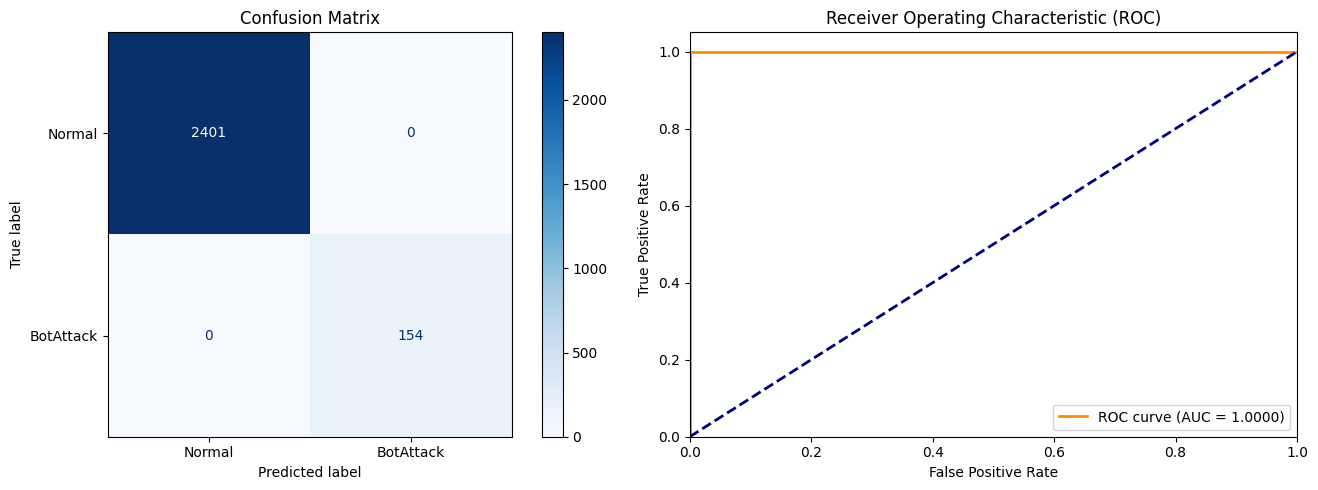

In [301]:
# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'BotAttack'])
disp.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

### SHAP Analysis for Best Model
Understand which features drive the model's predictions using SHAP values.

🔍 Computing SHAP values for feature importance...


<Figure size 1200x800 with 0 Axes>

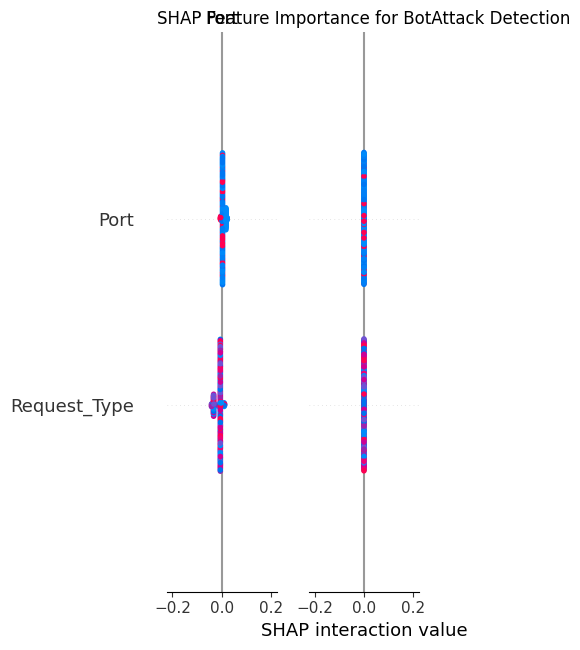

In [302]:
# SHAP analysis for Random Forest (FIXED)
print("🔍 Computing SHAP values for feature importance...")

# Use a sample for faster computation
sample_size = min(200, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

# For Random Forest binary classification, shap_values is a list [class_0, class_1]
# Use class 1 (BotAttack) for visualization
plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    # Binary classification - use positive class
    shap.summary_plot(shap_values[1], X_sample, plot_type="bar", show=False)
else:
    # Single array
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance for BotAttack Detection')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

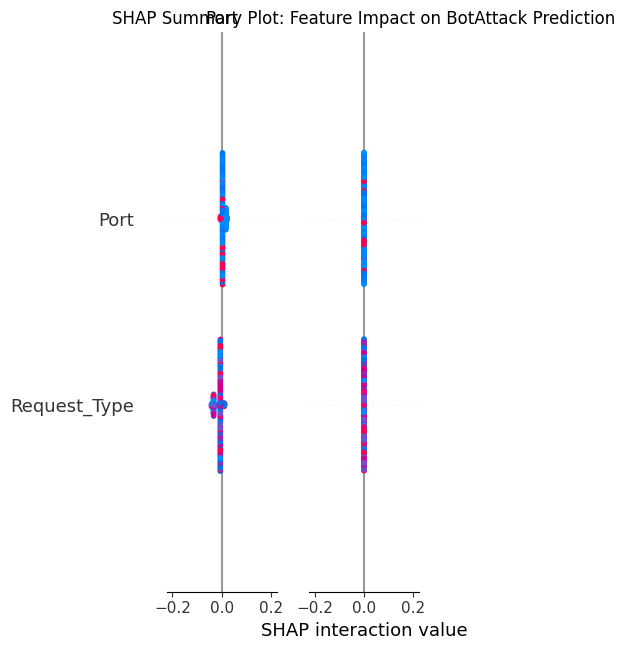

In [303]:
# SHAP summary plot (beeswarm) - shows feature impact direction (FIXED)
plt.figure(figsize=(12, 10))
if isinstance(shap_values, list):
    # Binary classification - use positive class
    shap.summary_plot(shap_values[1], X_sample, show=False)
else:
    shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Summary Plot: Feature Impact on BotAttack Prediction')
plt.tight_layout()
plt.show()

## Save the model

In [304]:
# Save the model for Spark integration
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the model
model_path = 'models/webbotshield_bot_detector.joblib'
joblib.dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

# Save feature names for inference
feature_names_path = 'models/feature_names.txt'
with open(feature_names_path, 'w') as f:
    f.write('\n'.join(X.columns.tolist()))
print(f"✅ Feature names saved to: {feature_names_path}")

# Save the scaler
scaler_path = 'models/scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

✅ Model saved to: models/webbotshield_bot_detector.joblib
✅ Feature names saved to: models/feature_names.txt
✅ Scaler saved to: models/scaler.joblib


In [305]:
# Summary of the model
print("="*60)
print("🎯 WEBBOTSHIELD ML MODEL SUMMARY")
print("="*60)
print(f"\n📊 Task: Binary Classification (Normal vs BotAttack)")
print(f"📈 Model: Random Forest Classifier")
print(f"🎓 Training samples: {len(X_train)} (after SMOTE)")
print(f"🧪 Test samples: {len(X_test)}")
print(f"📐 Features: {X.shape[1]}")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"📊 AUC-ROC: {roc_auc:.4f}")

print(f"\n🔧 Feature Categories:")
print("   - IP Aggregation: 6 features")
print("   - Temporal Aggregation: 2 features")
print("   - User-Agent: 3 features")
print("   - Request Pattern: 2 features")
print("   - Error: 2 features")
print("   - Original: Port, Payload_Size, Protocol, Request_Type")

print(f"\n📈 Data Augmentation: SMOTE applied on training data")

print(f"\n📁 Saved artifacts:")
print(f"   - Model: {model_path}")
print(f"   - Features: {feature_names_path}")
print(f"   - Scaler: {scaler_path}")

🎯 WEBBOTSHIELD ML MODEL SUMMARY

📊 Task: Binary Classification (Normal vs BotAttack)
📈 Model: Random Forest Classifier
🎓 Training samples: 11198 (after SMOTE)
🧪 Test samples: 2555
📐 Features: 16
✅ Accuracy: 1.0000
📊 AUC-ROC: 1.0000

🔧 Feature Categories:
   - IP Aggregation: 6 features
   - Temporal Aggregation: 2 features
   - User-Agent: 3 features
   - Request Pattern: 2 features
   - Error: 2 features
   - Original: Port, Payload_Size, Protocol, Request_Type

📈 Data Augmentation: SMOTE applied on training data

📁 Saved artifacts:
   - Model: models/webbotshield_bot_detector.joblib
   - Features: models/feature_names.txt
   - Scaler: models/scaler.joblib
